In this post I want to compare three algorithms: Hill Climbing, A-star and a genetic algorithm. They will be used to solve the same problem, the travelling salesman problem. I have done a little bit of work on this already in previous posts. First note that I am using the `search_2` module, which I created. The idea is to use the AIMA 4th edition data structures with the 1/2/3 edition implementation code. You can find it on my GitHub. 

Because I am using a very slow chromebook I have had to trim the romanian TSP problem by almost half. The hill climbing has no problem with the full problem: it is the A-star search that has a problem. To solve the TSP using a genetic algorithm I read the paper "Genetic Algorithms for the Travelling Salesman Problem: A Review of Representations and Operators" by P. LARRANAGA et al. and implemented crossovers that are discussed in the paper. I will discuss that further when we get to it.

In [2]:
from search_2 import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from Graph import *

romania = {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
           'F': (285, 460), 'N': (407, 561), 'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 
           'V': (535, 473)}

distances = {}
cities = []

for city in romania.keys():
    distances[city] = {}
    cities.append(city)

for name_1, coordinates_1 in romania.items():
        for name_2, coordinates_2 in romania.items():
            distances[name_1][name_2] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])
            distances[name_2][name_1] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])

def cost(route):
    c = 0
    for i in range(len(route)-1):
        c += distances[route[i]][route[i+1]]
    c += distances[route[0]][route[-1]]
    return c


First, we will look at Hill Climbing. The main part of hill climbing is selecting neighbours. In the code below I give two options: The first is called `two_opt`and the second is called `best_of_three_split`. In `two_opt` we take a random contiguous sub-array of the route, reverse it and put it back together. I thought this was over simplistic, yet this is the method on the AIMA repository. I came up with `best_of_three_split`. Here we take the route and split it into three contiguous sub-arrays and reverse the middle sub-array. We then join them up in the six possibly ways one can join three contiguous sub-arrays keeping track of the cost of each way. We then take the arrangement with the smallest cost and return that as a neighbour. This method is (at least) six-times more expensive thamn `two-opt` but results in a significant reduction in the number of iterations required to get the optimal route. This means, overall, we get the optimal soltuion quicker.

1369.4886803733975
EX TIME 0.7187695503234863


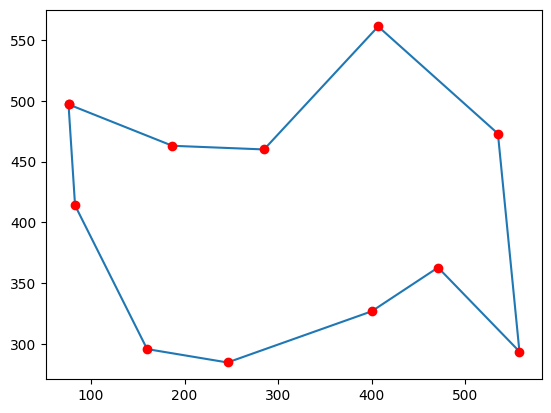

In [15]:
class TSP_hill_climbing(Problem):

    def two_opt(self, state):
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_list = list(neighbour_state)
        x = neighbour_list[left: right + 1]
        neighbour_list[left: right + 1] = x[::-1]
        neighbour_state = tuple(neighbour_list)
        return neighbour_state
    
    def best_of_three_split(self, state):
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
            
        neighbour_list = list(neighbour_state)        
        one = neighbour_list[: left]
        two = neighbour_list[left : right]
        two = two[::-1]
        three = neighbour_list[right : ]

        joined_states = []
        costs = []
        joined_states.append(one + two + three)
        costs.append(cost(joined_states[-1]))
        
        joined_states.append(one + three + two)
        costs.append(cost(joined_states[-1]))

        joined_states.append(two + one + three)
        costs.append(cost(joined_states[-1]))
        
        joined_states.append(two + three + one)
        costs.append(cost(joined_states[-1]))

        joined_states.append(three + one + two)
        costs.append(cost(joined_states[-1]))
        
        joined_states.append(three + two + one)
        costs.append(cost(joined_states[-1]))
        
        min_value = min(costs)
        min_index = costs.index(min_value)
        neighbour_list = joined_states[min_index]
        
        neighbour_state = tuple(neighbour_list)
        return neighbour_state
        
    def is_goal(self, state):
        return cost(state) < 1603
    
    def actions(self, state): 
        """The places neighboring `state`."""
        new_states = set()
        new_states.add(state)
        for i in range(10):
            new_state = self.best_of_three_split(state)
            #new_state = self.two_opt(state)
            new_states.add(new_state)
        return new_states
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        if(type(s1) == tuple):
            return cost(s1)
        if(type(s1) == list):
            return cost(tuple(s1))
       

    def value(self, state):
        return -1 * self.action_cost(None, None, state)

def hill_climbing(problem):
    
    def find_neighbors(state, number_of_neighbors=500):       
        neighbors = []
        
        for i in range(number_of_neighbors):
            new_state = problem.best_of_three_split(state)
            #new_state = problem.two_opt(state)

            neighbors.append(Node(new_state))
            state = new_state

        return neighbors

    # as this is a stochastic algorithm, we will set a cap on the number of iterations
    iterations = 25

    current = Node(problem.initial)
    
    while iterations:
        neighbors = find_neighbors(current.state)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) >= problem.value(current.state):
            current.state = neighbor.state
        iterations -= 1
        
    return current.state


tsp = TSP_hill_climbing(cities)
t0 = time.time()
path = hill_climbing(tsp)
t1 = time.time()
print(cost(path))
print("EX TIME", t1-t0)

data = []
for p in path:
    data.append(romania[p])
data.append(data[0])

x_val = [x[0] for x in data]
y_val = [x[1] for x in data]

plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.show()

As we can see, the hill climbing algorithm finds the optimal solution in 0.7 seconds. With some fine tuning, I think we could get the time down further again. Now let us look at A-star. I have had only good experiences with weighted A-star, so I will include that here also.

We all know how A-star works - a priority queue does most of the heavy lifting and we provide the algorithm with a heuristic that never overestimates the cost of getting from the current node to the goal node. Giving A-star a heuristic enables it to prune hopeless paths. In the implementation of A-star below I use a three-stage heuristic. The first two stages are simple: The smallest distance between an unvisited city and the current city, and the smallest distance between an unvisited city and the start city. The final stage uses the minimum spanning tree (MST) of a graph made up of nodes that correspond to the cities, and edges the costs of travelling from the connecting cities. We obtain the MST using Kruskal's algorithm. This is a simple algorithm. We basically loop through the edges, which are sorted according to cost, and introduce an edge to the MST if we don't introduce a cycle.

initial route ('A',)
initial route length 1
initial route cost 0.0
('A', 'T', 'D', 'C', 'B', 'U', 'E', 'V', 'N', 'F', 'S')
weighted astar
PATH COST 1369.4886803733978
EX TIME 43.13364887237549
('A', 'T', 'D', 'C', 'B', 'U', 'E', 'V', 'N', 'F', 'S')
astar
PATH COST 1369.4886803733978
EX TIME 68.24704599380493


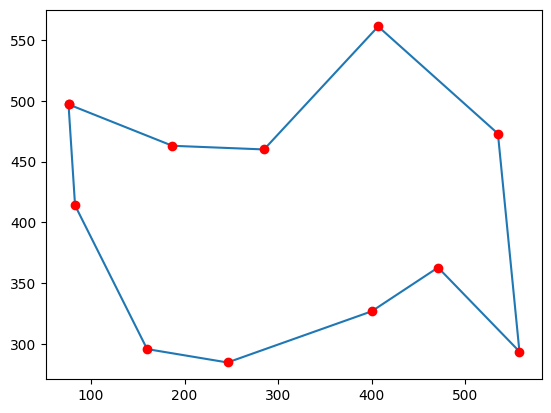

In [17]:
class TSP_graph_search(Problem):
    
    def is_goal(self, state):
        return len(state) == len(romania)
        
    def actions(self, state): 
        """The places neighboring `state`."""
        visited = list(state)
        unvisited = [x for x in cities if x not in visited]
        new_states = set()
        for i in unvisited:
            new_state = state
            new_state = new_state + (i,)
            new_states.add(new_state)
        return new_states
        
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return cost(action)

    def h(self, n):
        visited = list(n.state)
        unvisited = [x for x in cities if x not in visited]
        #print("unvisited", unvisited)
        # There are three components to this heurisitc:
        #    1) smallest distance to the nearest unvisited city from the current city
        current_city = n.state[-1]
        if not unvisited:
            return 0
        min_city = unvisited[0]
        min_distance_current = distances[current_city][min_city]
        for c in unvisited:
            if distances[current_city][c] < min_distance_current:
                min_distance_current = distances[current_city][c]
                min_city = c
        #    2) nearest distance from an unvisited city to the start city
        start_city = n.state[0]
        if not unvisited:
            return 0
        min_city = unvisited[0]
        min_distance_start = distances[start_city][min_city]
        for c in unvisited:
            if distances[start_city][c] < min_distance_start:
                min_distance_start = distances[start_city][c]
                min_city = c
        #    3) estimated distance to travel all the unvisited cities 
        #       (MST heuristic used here)
        rint = {}
        keys = unvisited
        for k in range(len(keys)):
            rint[keys[k]] = k
            
        g = Graph(len(keys))
        for c1 in keys:
            for c2 in keys:
                if c1 == c2:
                    continue
                g.add_edge(rint[c1], rint[c2], distances[c1][c2])

        mst = g.kruskal_mst()
        total_weight = 0
        for u, v, weight in mst:
            total_weight = total_weight + weight
        
        return min_distance_current + min_distance_start + total_weight

    def h_weighted(self, n):
        return 2*self.h(n)
        

initial_route = tuple('A')

print("initial route", initial_route)
print("initial route length", len(initial_route))
print("initial route cost", cost(initial_route))

def astar_mst(problem): return astar_search(problem, h=problem.h)
def astar_mst_weighted(problem): return astar_search(problem, h=problem.h_weighted)

r0 = TSP_graph_search(initial = initial_route)
t0 = time.time()
path = path_states(astar_mst_weighted(r0)) 
t1 = time.time()
print(path[-1])
print("weighted astar")
print("PATH COST", cost(path[-1]))
print("EX TIME", t1- t0)

t0 = time.time()
path = path_states(astar_mst(r0)) 
t1 = time.time()
print(path[-1])
print("astar")
print("PATH COST", cost(path[-1]))
print("EX TIME", t1- t0)

data = []
for p in path[-1]:
    data.append(romania[p])
data.append(data[0])

x_val = [x[0] for x in data]
y_val = [x[1] for x in data]

plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.show()

First, note that A* takes over a minute to find the optimal solution. The only positive we can take from this is that A* will always find the optimal solution. Also, we can see that weighted A* takes over 20 seconds less to find the same soltution. But we need to remember that weighted A* is not guaranteed to find the optimal solution. In this case it does land on the optimal soltuion. 

Now we need to turn our attention to the genetic algorithm. The genetic algorithm has three components: hereditary, selection and variation (see my last blog for more on this). With regards to the TSP, selection is simple. We select paths (chromosomes) with the route between cities (genes) with the smallest possible total distance. Variation is also simple, we just pick a pair of cities on a route and swap them with some small probability. The difficulty resides in passing genetic information from parents to children. There are many ways we can do this, I have chosen two methods from "Genetic Algorithms for the Travelling Salesman Problem: A Review of Representations and Operators" by P. LARRANAGA et al. and implemented them the best I can. 

In [27]:
def fitness_threshold(fitness_fn, f_thres, population):
    if not f_thres:
        return None

    fittest_individual = max(population, key=fitness_fn)
    if fitness_fn(fittest_individual) >= f_thres:
        return fittest_individual

    return None

def genetic_algorithm(population, fitness_fn, gene_pool=[0, 1], f_thres=None, ngen=1000, pmut=0.1):
    """[Figure 4.8]"""
    for i in range(ngen):
        population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)
                      for i in range(len(population))]

        fittest_individual = fitness_threshold(fitness_fn, f_thres, population)
        if fittest_individual:
            return fittest_individual


    return max(population, key=fitness_fn)

def select(r, population, fitness_fn):
    fitnesses = map(fitness_fn, population)
    sampler = weighted_sampler(population, fitnesses)
    return [sampler() for i in range(r)]

def recombine(x, y):
    return cycle_crossover(x, y)

def cycle_crossover(A, B):
    data = [A, B]
    n = len(A)
    child = [None] * n
    c = random.choice([0,1])
    # the first cycle
    child[0] = data[c][0]
    cycle = [data[c][0]]
    n = data[1-c].index(data[c][0])
    child[n] = data[c][n]
    cycle.append(data[c][n])

    while(cycle[-1] != cycle[0]):
        n = data[1-c].index(cycle[-1])
        child[n] = data[c][n]
        cycle.append(data[c][n])

    while(None in child):
        i = child.index(None)
        child[i] = data[1-c][i]
        cycle = [data[1-c][i]]
        n = data[c].index(data[1-c][i])
        child[n] = data[1-c][n]
        cycle.append(data[1-c][n])
        while(cycle[-1] != cycle[0]):
            n = data[c].index(cycle[-1])
            child[n] = data[1-c][n]
            cycle.append(data[1-c][n])
        c = 1-c
    
    return child

def partially_mapped_crossover(A, B):
    n = len(A)
    left = random.randint(0, n - 1)
    right = random.randint(0, n - 1)
    if left > right:
        left, right = right, left
    AS = A[left : right]
    BS = B[left : right]
    A[left : right] = BS
    B[left : right] = AS

    # create mapping
    map_1 = {}
    map_2 = {}
    for i in range(left, right):
        map_1[A[i]] = B[i]
        map_2[B[i]] = A[i]

    # map duplicates
    R = list(range(left)) + list(range(right, n))
    for i in R:
        while A[i] in BS:
            A[i] = map_1[A[i]]
        while B[i] in AS:
            B[i] = map_2[B[i]]
    return random.choice([A,B])


def mutate(x, gene_pool, pmut):
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    c = random.randrange(0, n)
    r = random.randrange(0, n)

    temp = x[c]
    x[c] = x[r]
    x[r] = temp
    return x

Before we move on we have to modify the way in which the initial population is generated. Each city can only appear once.

In [28]:
def init_population(pop_number, gene_pool, state_length):
    g = len(gene_pool)
    population = []
    for i in range(pop_number):
        K = gene_pool
        random.shuffle(K)
        population.append(K)

    return population

In [29]:
def fitness_fn(n):
    return 5000 - cost(n) 

EX TIME 75.20848274230957
['V', 'N', 'B', 'U', 'F', 'A', 'T', 'S', 'D', 'C', 'E']


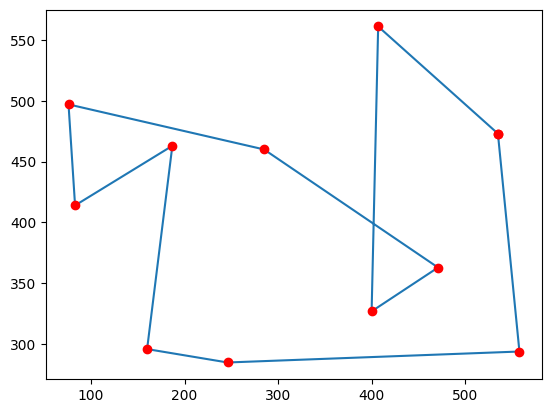

In [32]:
gene_pool = list(romania.keys())
population = init_population(400, gene_pool, len(gene_pool))
t0 = time.time()
path = genetic_algorithm(population, fitness_fn, gene_pool, f_thres=None, ngen=150, pmut=0.1)
t1 = time.time()
print("EX TIME", t1 - t0)
print(path)
data = []
for p in path:
    data.append(romania[p])
data.append(data[0])

x_val = [x[0] for x in data]
y_val = [x[1] for x in data]

plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.show()